In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("../data/processed_data.csv", parse_dates=["date"])

df["year"] = df["date"].dt.year
df["white_outcome"] = (3 - df["white_score"] * 2).astype(int)

train = df.loc[df["date"] < "2019-01-01"]
test = df.loc[df["date"] >= "2019-01-01"]

In [3]:
cols = ["white_elo", "black_elo"]

In [4]:
clf = RandomForestClassifier()
clf.fit(train[cols].values, train["white_outcome"].values)

RandomForestClassifier()

In [11]:
ypred = clf.predict_proba(test[cols].values)

ypred_cls = np.argmax(ypred, axis=1) + 1

In [12]:
np.mean(ypred_cls == test["white_outcome"].values)

0.4341801385681293

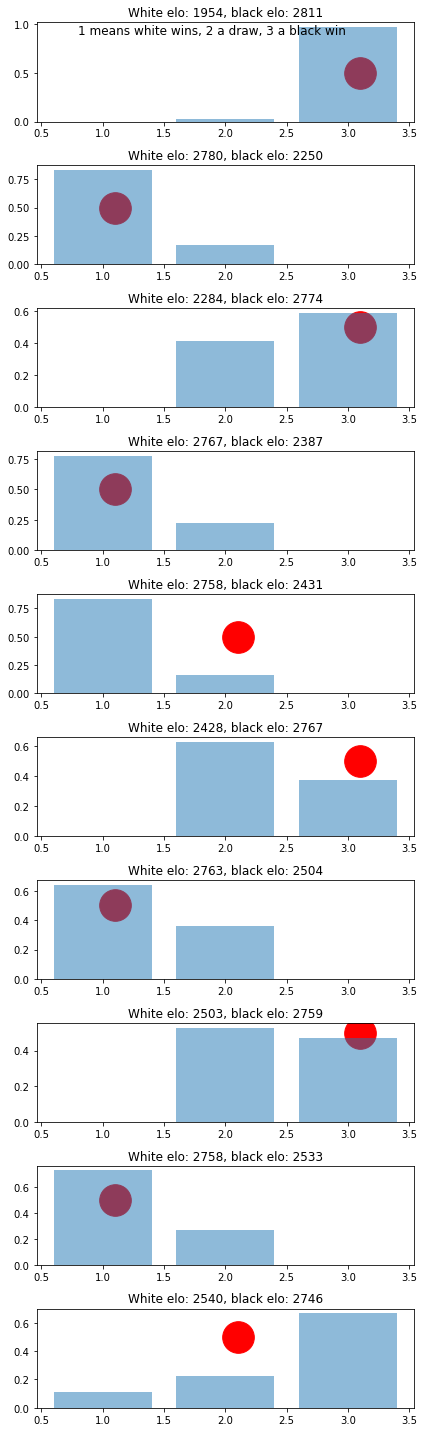

In [30]:
plot_n = 10
reverse = False

fig, ax = plt.subplots(plot_n, 1, figsize=(6, 20))
ax = ax.ravel()

for i in range(plot_n):
    ax[i].scatter(
        test["white_outcome"].values[i] + 0.1, 0.5, color="red", s=1000
    )
    ax[i].bar(range(1, 4), ypred[i, :], alpha=0.5)
    ax[i].set_title(
        f"White elo: {test.white_elo.values[i]:.0f}, black elo: {test.black_elo.values[i]:.0f}"
    )
plt.tight_layout()
plt.suptitle("1 means white wins, 2 a draw, 3 a black win");